## Basic usage of Stacking Variational Bayesian Monte Carlo (S-VBMC)

This notebook shows the usage of the `SVBMC` class to combine ("stack") posteriors from different [Variational Bayesian Monte Carlo (VBMC)](https://github.com/acerbilab/pyvbmc/tree/main) inference runs, optimizing the Evidence Lower BOund (ELBO) of the resulting "stacked" posterior.

S-VBMC is a fast and inexpensive post-processing step, boosting inference performance at a very contained computational cost. This approach is especially useful when separate VBMC runs give different results, i.e. when VBMC "discovers" different portions of the posterior in different runs (see below for a more detailed explanation).

The `SVBMC` class takes a list of variational posteriors obtained from individual VBMC runs as inputs, in the form of `VariationalPosterior` objects output by VBMC. These objects can be found in the form of `.pkl` files in this repository in the folders `vbmc_runs/GMM` (for the first example, 10 runs) and `vbmc_runs/Ring` (for the second example, 10 runs).

**Optionally**, you might compute the VBMC variational posteriors yourself with the function `compute_vps` in this notebook (note that this might take some time, depending on the number of VBMC runs you wish to perform). This choice is regulated by the global variable `skip_VBMC` in the cell below. Set it to `True` if you wish to load the `VariationalPosterior` objects, and to `False` if you prefer to produce them yourself with VBMC.  

In [1]:
# Set to `True` if you want to load the variational posteriors, 
# to `False` if you want to compute them with PyVBMC

skip_VBMC = True


Let's start with imports. 

In [2]:
import pickle
from pyvbmc import VBMC # PyVBMC is the python implementation of VBMC
from svbmc.svbmc import SVBMC
from svbmc.utils import overlay_corner_plot, find_init_bounds # handy functions
from svbmc.targets import GMM, Ring # Targets
import numpy as np
import glob


### How to use VBMC (optional)

Let's first briefly discuss some relevant aspects of VBMC and how to use it. 

VBMC is an approximate inference technique that relies on an active learning strategy, exploring the parameter space based on what parameter regions are deemed more "promising". This allows it to keep to a minimum the number of target evaluations, making VBMC ideal in scenarios where such evaluation is expensive. However, where the target has particularly complex properties, such as multiple distant modes (like in Example 1), or a slim and curved shape (like in Example 2), a conservative exploration strategy might cause VBMC to miss some high probability mass regions (e.g., remaining "stuck" around a mode). In this notebook, we'll see how S-VBMC fixes this problem.


To run VBMC, we need to provide the algorithm certain inputs. These are:

- A callable function `log_density`, which given parameters `x` returns the unnormalized log-posterior (i.e., the log-joint);
- A starting point `x0`, specifying an initial value of `x` to start the exploration of the target from;
- Lower and upper bounds (`LB` and `UB`, respectively) specifying the minimum and maximum values `x` can take;
- Plausible lower and upper bounds (`PLB` and `PUB`, respectively) specifying the minimum and maximum values `x` is likely to take.

For `log_density`, we can use the `.log_pdf()` method of our target classes (`GMM` and `Ring`, see below). Note that in real-world scenarios this should be your model's log-joint, meaning the sum of your log-prior (which you will have to set based on your knowledge of the problem) and log-likelihood. 

As our parameters are unbounded in both examples, we could omit specifying `LB` and `UB`, and VBMC would know to work in an unbounded parameter space. However, here we specify them as `np.array([-np.inf, -np.inf])` and `np.array([np.inf, np.inf])` respectively for completeness.

Finally, as we have full knowledge of our targets, we can confidently specify `np.array([-10, -10])` as our `PLB` and `np.array([10, 10])` as our `PUB` in both examples. This will keep VBMC's exploration of the target relatively contained to parameter regions likely to have high probability mass. In a real-world scenario (where the ground truth is not available), you will have to rely on your knowledge of the problem to set these boundaries.

As part of its outputs, VBMC returns a `VariationalPosterior` object. This contains, among other things, the sufficient statistics of the variational posterior (a mixture of `K` Gaussians), an estimate of the ELBO, and, crucially, estimates of the individual components of the expected log-joint (one for each Gaussian component). The latter in particular play a key role in S-VBMC; however, a discussion of the mathematical details is beyond the scope of this tutorial (refer to the [paper](https://arxiv.org/abs/2504.05004) for further explanations). We mention these here because they will be brought up later in the notebook when we filter out "bad" VBMC runs. 

For more (and more detailed) examples on how to use VBMC, refer to [these notebooks](https://github.com/acerbilab/pyvbmc/tree/main/examples).

Now we need a function to run VBMC `M` times and store the resulting `VariationalPosterior` objects in a list, which we will use later as the input for S-VBMC.

For each VBMC run, we choose a different initialization point sampled uniformly within the plausible bounds `PLB` and `PUB` (if these are not available the function will use `LB` and `UB`, but this won't happen in our examples). Given a sufficient number of runs, this increases the chances that all parameter regions with high probability mass are explored at least once, which is all S-VBMC needs.

In [3]:
def compute_vps(
        log_density : callable, 
        LB: np.ndarray = None,
        UB: np.ndarray = None,
        PLB: np.ndarray = None,
        PUB: np.ndarray = None,
        M: int = 10
    ):
    """
    This function runs VBMC `M` times, stores the resulting ``VariationalPosterior`` 
    objects in a list, and returns that list.
    
    NOTE: At least one of `LB`, `UB`, `PLB` and `PUB` must be specified as an array with the 
    same dimensionality as the inference problem.

    Parameters:
    -----------
    log_density : callable
        A given target log-density (unnormalized log-posterior) used by VBMC
        to compute a variational posterior. 
    LB, UB : np.ndarray, optional
        Inputs for VBMC. They represent lower (`LB`) and upper (`UB`) bounds 
        for the coordinate vector, `x`, so that the posterior has support on 
        `LB` < `x` < `UB`. If scalars, the bound is replicated in each dimension. 
        Use ``None`` for `LB` and `UB` if no bounds exist. Set `LB` [`d`] = -`inf`
        and `UB` [`d`] = `inf` if the `d`-th coordinate is unbounded (while
        other coordinates may be bounded). Note that if `LB` and `UB` contain
        unbounded variables, the respective values of `PLB` and `PUB` need to
        be specified (see below). If `PLB` and `PUB` are not specified, the starting
        point `x0` of the algorithm will be uniformly sampled within `LB` and `UB` 
        (see below). Both are by default `None`.
    PLB, PUB : np.ndarray, optional
        Inputs for VBMC. They represent a set of plausible lower (`PLB`) and upper (`PUB`)
        bounds such that `LB` < `PLB` < `PUB` < `UB`.
        Both `PLB` and `PUB` need to be finite. `PLB` and `PUB` represent a
        "plausible" range, which should denote a region of high posterior
        probability mass. Among other things, the plausible box is used by VBMC to
        draw initial samples and to set priors over hyperparameters of the
        algorithm. If `PLB` and `PUB` are specified, the starting point `x0` 
        of the algorithm will be uniformly sampled within `PLB` and `PUB`.
        Both are by default `None`.
    M : int
        Number of times VBMC should be run. 

    Returns:
    --------
    vp_list : list[VariationalPosterior] of length `M`
        List of variational posteriors obtained with VBMC. 
    """

    
    # Initialize vp_list
    vp_list = []

    # Determine sampling bounds for `x0`
    sample_LB, sample_UB = find_init_bounds(LB, UB, PLB, PUB)

    # Run inference `M` times
    for _ in range(M):
        
        # Sample starting point uniformly within plausible bounds
        x0 = np.random.uniform(sample_LB, sample_UB)

        #### start VBMC usage ####

        # Initialize VBMC object
        vbmc = VBMC(
            log_density = log_density, 
            x0 = x0, 
            upper_bounds=UB, 
            lower_bounds=LB, 
            plausible_upper_bounds=PUB, 
            plausible_lower_bounds=PLB
        )
        # Run inference
        vp, _ = vbmc.optimize()

        #### end VBMC usage ####

        vp_list.append(vp)

    return vp_list

Let's now define a function to load existing `.pkl` files containing pre-computed variational posteriors, in case you don't want to run VBMC. Using these will save a considerable amount of time.

In [4]:
def load_vps(
        target_name : str
    ):
    
    vp_list = []

    vp_files = glob.glob(f"../vbmc_runs/{target_name}/*.pkl") # change if necessary

    for file in vp_files:
        with open(file, "rb") as f:
            vp_list.append(pickle.load(f))

    return vp_list

Now we are all set to run S-VBMC on our examples!

### Example 1: Multimodal target

One situation in which VBMC is likely to yield suboptimal results is when the target distribution has multiple, distant modes. We use this as our first example, showcasing how, while VBMC tends to get stuck overexploring the parameter region around one or two individual modes, stacking different (randomly initialized) runs manages to capture the full distribution effectively, if enough runs are combined. Generally, we recommend setting `M` to 10, as we found that this drastically improves posterior quality across problems at a negligible computational cost. 

Let's start by plotting our target using samples taken directly from it.


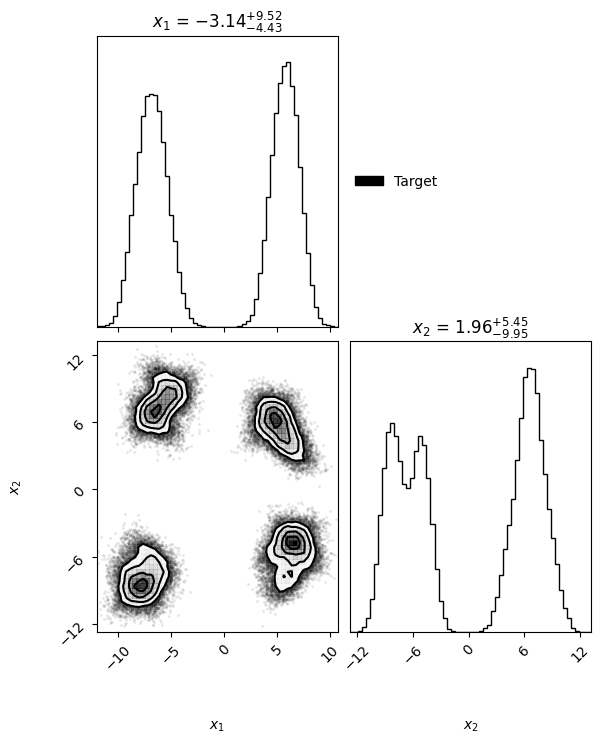

In [5]:
# Initialize GMM object. With no inputs it will use default settings (i.e., as in the paper)
gmm = GMM()

# Sample directly from the target
X_gmm_gt = gmm.sample(100000)

_ = overlay_corner_plot(
    [X_gmm_gt], # list of samples, just one in this case
    labels = ["Target"], # label for legend
    colors = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

Now let's either load or compute our VBMC posteriors. 

Remember, if the global variable `skip_VBMC` is set to `False` the following cell will run VBMC `M` times (which will take roughly `M` minutes). If it's set to `True`, the pre-computed variational posteriors will be loaded.   

In [6]:

# Load variational posteriors
if skip_VBMC:
    vp_list_gmm = load_vps("GMM")
else:
    # Set parameter bounds
    LB = np.array([-np.inf, -np.inf]) # absolute lower bounds
    UB = np.array([np.inf, np.inf]) # absolute upper bounds
    PLB = np.array([-10, -10]) # plausible lower bounds
    PUB = np.array([10, 10]) # plausible upper bounds

    # Compute `M` variational posteriors with random initialization
    vp_list_gmm = compute_vps(
        log_density = gmm.log_pdf, 
        LB = LB,
        UB = UB,
        PLB = PLB,
        PUB = PUB,
        M = 10
    )

Let's plot a couple of posteriors (overlayed with the ground truth) to see how VBMC did.

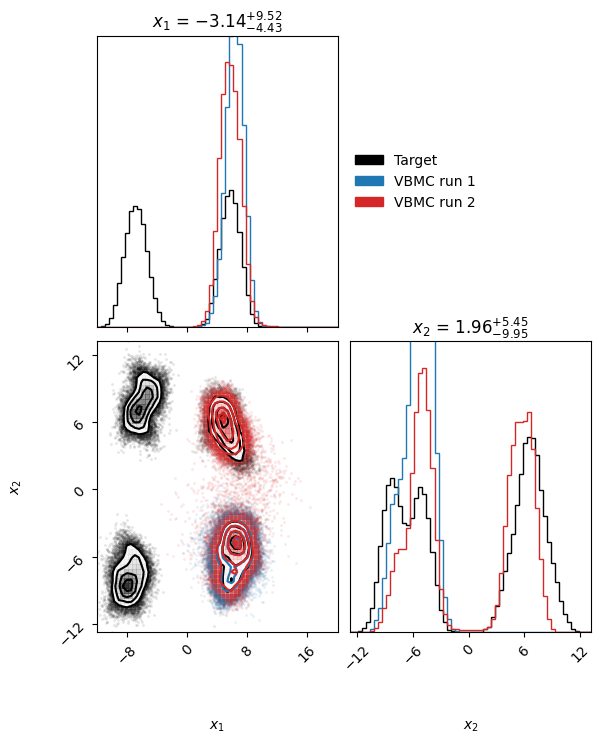

In [7]:
# Take samples
vbmc_samples_gmm = []

for m in range(2):
    Xs, _ = vp_list_gmm[m].sample(X_gmm_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_gmm.append(Xs)

# Plot
_ = overlay_corner_plot([X_gmm_gt] + vbmc_samples_gmm, 
                        labels = ["Target", "VBMC run 1", "VBMC run 2"], 
                        colors = ["black", "tab:blue", "tab:red"], 
                        base=4, 
                        bins=60)

Most likely, you will see that VBMC has missed some high probability mass regions, remaining stuck on one (or two) modes. 

Let's see if S-VBMC can fix this. Given a list of `VariationalPosterior` objects obtained by running VBMC multiple times (here `vp_list`), our approach can be implemented in a few lines of code.

**NOTE**: One should only use properly converged VBMC runs as input for S-VBMC. Luckily, [VBMC](https://github.com/acerbilab/pyvbmc/tree/main) offers good diagnostic tools to determine this, so it's easy to set up filters. First and foremost, we filter out runs not marked as "stable". For our second filter, we consider the estimations of the individual components of the expected log-joint ($I_{k}$ in the [paper](https://arxiv.org/abs/2504.05004)) computed by VBMC for each run, mentioned above. In addition to these estimates, VBMC outputs the uncertainty associated with them in the form of a covariance matrix $J_{k, k'}$. As accurate estimations of $I_{k}$ are crucial in S-VBMC, we filter out VBMC runs where at least one of these has excessive uncertainty associated with it. In practice, we found that eliminating runs where the highest variance associated with a component has a value of 5 or more works well. Refer to the [paper](https://arxiv.org/abs/2504.05004) for a more in-depth discussion of these variables and their role in S-VBMC.


In [8]:
# Filtering out bad runs, if present
before_filter = len(vp_list_gmm) 
vp_list_gmm = [vp for vp in vp_list_gmm if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_gmm) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialize SVBMC object
vp_stacked_gmm = SVBMC(vp_list=vp_list_gmm)

# Optimize stacked ELBO
vp_stacked_gmm.optimize()

print(f'Stacked ELBO: {vp_stacked_gmm.elbo["estimated"]}') # The target is noiseless, so there is no need for debiasing

0 bad runs removed 


Optimizing the stacked ELBO w.r.t. all weights
Initial elbo = 3.003857198453776
iter 5: elbo = 3.012568656017453
iter 10: elbo = 2.981527511805427
Stacked ELBO: 3.0208052672296244


Let's visualize the stacked posterior and see how it compares to the ground truth.


**IMPORTANT NOTE**: 

You must use samples from the stacked posterior for any application and should **not** interpret its individual components' sufficient statistics (means and covariance matrices).

This is because each VBMC run may use different internal parameter transformations. Consequently, the component means and covariance matrices from different VBMC posteriors exist in **incompatible parameter spaces**. Combining them creates a mixture whose individual Gaussian components are not directly meaningful.

**Always use samples from the final stacked posterior**, which are correctly transformed back into the original parameter space. These are available via the `.sample()` method:

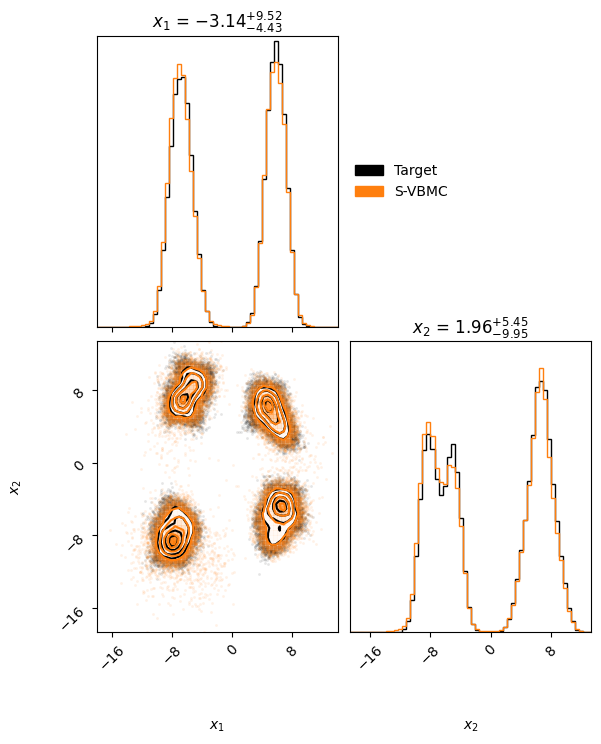

In [9]:
# Take samples from stacked posterior
svbmc_samples_gmm = vp_stacked_gmm.sample(X_gmm_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_gmm_gt, svbmc_samples_gmm], 
        labels = ["Target", "S-VBMC"], 
        colors = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

The stacked posterior should now cover all four modes (if you used a sufficient number of variational posteriors), showing a very good match with the ground truth. Let's now try another example.

### Example 2: Ring target

Another situation in which VBMC is likely to perform poorly is when the target distribution is long, curvy and slim. Here we use a ring-shaped target, let's have a look at it.


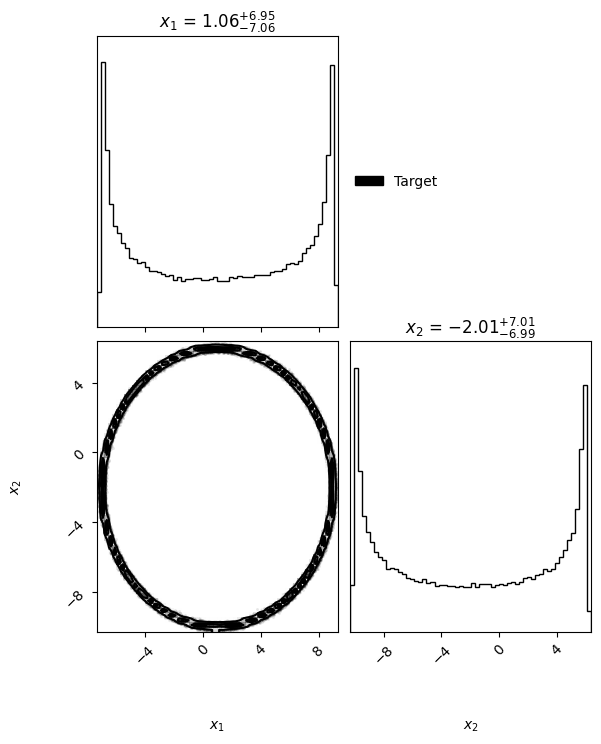

In [10]:
# Initialize           
ring = Ring()

# Sample
X_ring_gt = ring.sample(100000)

_ = overlay_corner_plot(
    [X_ring_gt], # list of samples, just one in this case
    labels = ["Target"], # label for legend
    colors = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

As before, let's check how VBMC does here. Again, if the global `skip_VBMC` was set to `False` at the beginning of the notebook, the following cell will run VBMC `M` times (which will take a bit longer than the previous example, roughly `2*M` minutes). If you wish to load the pre-computed variational posteriors, set it to `True`.

In [11]:
if skip_VBMC:
    vp_list_ring = load_vps("Ring")
else:
    # Set parameter bounds
    LB = np.array([-np.inf, -np.inf]) # absolute lower bounds
    UB = np.array([np.inf, np.inf]) # absolute upper bounds
    PLB = np.array([-10, -10]) # plausible lower bounds
    PUB = np.array([10, 10]) # plausible upper bounds

    # Compute `M` variational posteriors with random initialization
    vp_list_ring = compute_vps(
        log_density = ring.log_pdf, 
        UB = UB, 
        LB = LB, 
        PLB = PLB, 
        PUB = PUB, 
        M = 10)


Let's plot a couple and visually inspect the result.

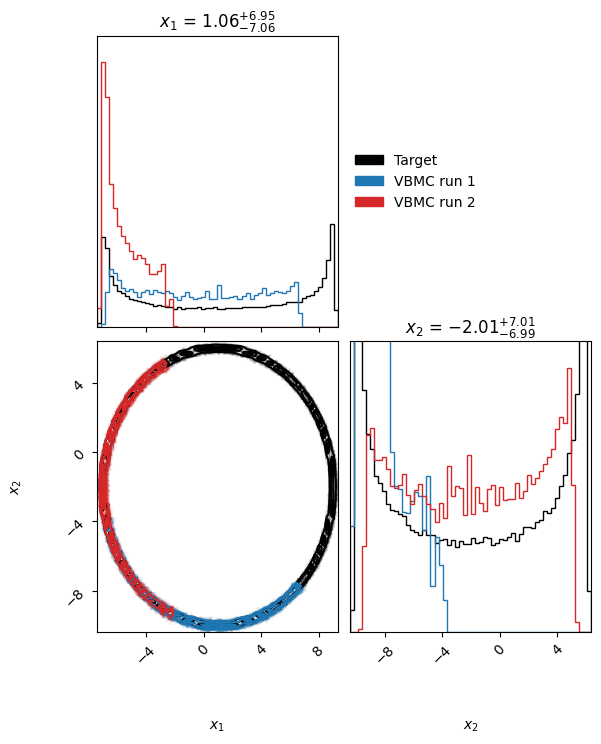

In [12]:
# Take samples
vbmc_samples_ring = []

for m in range (2):
    Xs, _ = vp_list_ring[m].sample(X_ring_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_ring.append(Xs)

# Plot
_ = overlay_corner_plot(samples = [X_ring_gt] + vbmc_samples_ring, 
                        labels = ["Target", "VBMC run 1", "VBMC run 2"], 
                        colors = ["black", "tab:blue", "tab:red"], 
                        base=4, 
                        bins=60 
                        )

Again, VBMC fails to cover the whole posterior. However, thanks to the random intialization, different runs cover different portions of it, which makes the idea of stacking them very promising. Let's see if S-VBMC improves things.

In [13]:
# Filtering out bad runs, if present
before_filter = len(vp_list_ring) 
vp_list_ring = [vp for vp in vp_list_ring if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_ring) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialize SVBMC object
vp_stacked_ring = SVBMC(vp_list=vp_list_ring)

# Optimize stacked ELBO
vp_stacked_ring.optimize()

print(f'Stacked ELBO: {vp_stacked_ring.elbo["estimated"]}')



0 bad runs removed 


Optimizing the stacked ELBO w.r.t. all weights
Initial elbo = 2.2186080161659714
iter 5: elbo = 2.2701478982687293
iter 10: elbo = 2.2636114280590784
iter 15: elbo = 2.2776885529121857
iter 20: elbo = 2.2906533511412954
Stacked ELBO: 2.3003906334693447


And now let's plot the result.

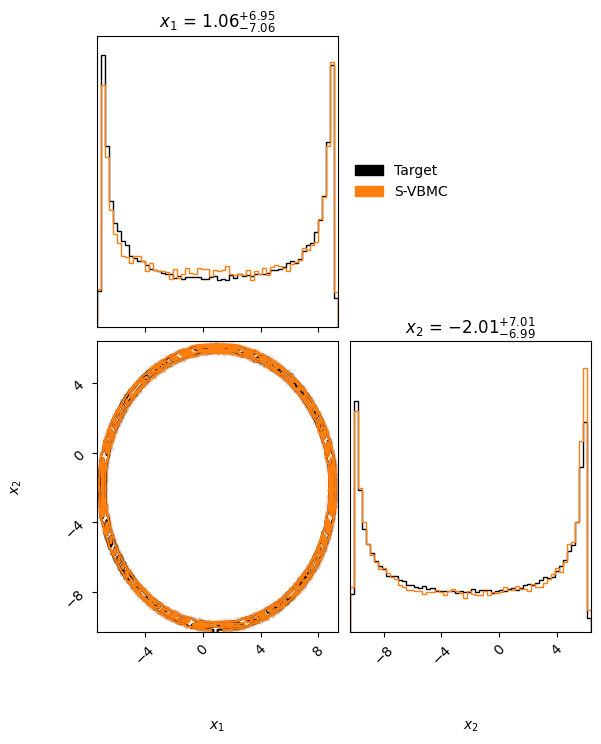

In [14]:
# Take samples from stacked posterior
svbmc_samples_ring = vp_stacked_ring.sample(X_ring_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_ring_gt, svbmc_samples_ring], 
        labels = ["Target", "S-VBMC"], 
        colors = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

As before, S-VBMC effectively combined VBMC posteriors into a much better global approximation of the true target. The quality of the posterior will depend on how many variational posteriors were stacked, but generally `M` $\approx$ 10 should be sufficient. 